In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations

import numpy as np

from mhsxtrapy.b3d import WhichSolution
from mhsxtrapy.examples import multipole
from mhsxtrapy.field2d import Field2dData, FluxBalanceState, check_fluxbalance
from mhsxtrapy.field3d import calculate_magfield
from mhsxtrapy.plotting.vis import (
    plot_ddensity_xy,
    plot_ddensity_z,
    plot_dpressure_xy,
    plot_dpressure_z,
    plot_magnetogram_2D,
    plot_magnetogram_3D,
)

The following packages are not installed:
['mpl-animators>=1.0.0', 'reproject>=0.9.0']
To install sunpy with these dependencies use `pip install sunpy[map]` or `pip install sunpy[all]` for all extras. 
If you installed sunpy via conda, please report this to the community channel: https://matrix.to/#/#sunpy:openastronomy.org [sunpy.util.sysinfo]
The following packages are not installed:
['mpl-animators>=1.0.0']
To install sunpy with these dependencies use `pip install sunpy[visualization]` or `pip install sunpy[all]` for all extras. 
If you installed sunpy via conda, please report this to the community channel: https://matrix.to/#/#sunpy:openastronomy.org [sunpy.util.sysinfo]
/Users/lilli/Library/Caches/pypoetry/virtualenvs/mhsxtrapy-_witMKZG-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Example for magnetic field extrapolation from analytical boundary condition instantiated "by hand" and for all three different solutions

##### Instantiate boundary condition 

We instantiate the boundary condition manually from the analytical expression given in the following cell using the function multipole(x, y).

We choose a grid resolution of 200 in x- and y-direction (and resulting number of Fourier modes = 200) as well as resolution in z-direction of 400. We want the boundary condition to extend to 20L (= 20 Mm) in all directions. Therefore, the extrapolation will lead to a 3D data cube.

We define the normalising magnetic field strength as 500 Gauss. 

In [3]:
nx, ny, nz, nf = 200, 200, 400, 200
xmin, xmax, ymin, ymax, zmin, zmax = 0.0, 20.0, 0.0, 20.0, 0.0, 20.0

"""
Calculation of pixel sizes and arrays of x-, y- and z-extension of box. 
"""
pixelsize_x = (xmax - xmin) / nx
pixelsize_y = (ymax - ymin) / ny
pixelsize_z = (zmax - zmin) / nz

x_arr = np.linspace(xmin, xmax, nx, dtype=np.float64)
y_arr = np.linspace(ymin, ymax, ny, dtype=np.float64)
z_arr = np.linspace(zmin, zmax, nz, dtype=np.float64)

B_PHOTO = 500

data_bz = np.zeros((ny, nx))

for ix in range(0, nx):
    for iy in range(0, ny):
        x = x_arr[ix] / 10.0
        y = y_arr[iy] / 10.0
        data_bz[iy, ix] = multipole(x, y)

##### Check if flux through boundary condition is balanced

check_fluxbalance returns the summation of the flux through the bottom boundary, normalised by the sum of absolute values. This returns a value between −1 and 1, where either extreme corresponds to the flux being directed entirely inward or entirely outward, respectively. We consider values between −0.01 and 0.01 as flux-balanced in agreement with Wiegelmann & Sakurai (2021). 

In [4]:
np.fabs(check_fluxbalance(data_bz)) < 0.01

False

##### Instantiate Field2dData object from analytical boundary condition and plot 2D boundary condition

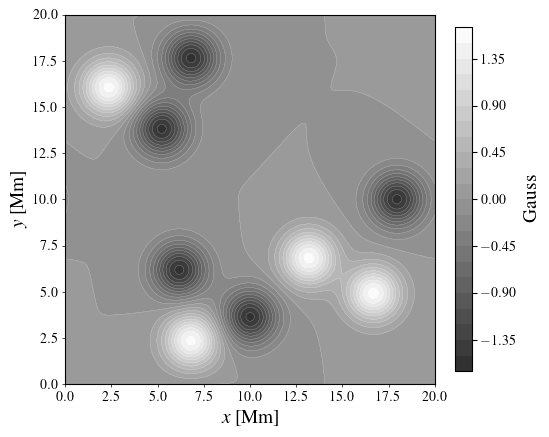

In [5]:
data2d = Field2dData(
    nx,
    ny,
    nz,
    nf,
    pixelsize_x,
    pixelsize_y,
    pixelsize_z,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
    flux_balance_state=FluxBalanceState.UNBALANCED,
)

plot_magnetogram_2D(data2d)

##### Extrapolate magnetic field 

Use asymptotic solution presented in Nadol and Neukirch (2025) and choosen parameters alpha, a, b, z0 and delta z. 

In [6]:
data3d = calculate_magfield(
    data2d,
    alpha=0.05,
    a=0.22,
    which_solution=WhichSolution.ASYMP,
    b=1.0,
    z0=2.0,
    deltaz=0.2,
)

Use asymptotic solution presented in Neukirch and Wiegelmann (2019) and choosen parameters alpha, a, b, z0 and delta z. 

In [ ]:
data3d_NW = calculate_magfield(
    data2d,
    alpha=0.05,
    a=0.22,
    which_solution=WhichSolution.NEUWIE,
    b=1.0,
    z0=2.0,
    deltaz=0.2,
)

Use asymptotic solution presented in Low (1991, 1992) and choosen parameters alpha and kappa.

In [ ]:
data3d_LOW = calculate_magfield(
    data2d,
    alpha=0.05,
    a=0.22,
    kappa=1 / 2.0,
    which_solution=WhichSolution.LOW,
    b=1.0,
    z0=2.0,
    deltaz=0.2,
)

##### Plot magnetogram

In [ ]:
plot_magnetogram_3D(data3d, view="los", footpoints="active-regions")

##### Plot pressure variation with height z

In [ ]:
plot_dpressure_z(data3d)

##### Plot density variation with height z

In [ ]:
plot_ddensity_z(data3d)

##### Plot pressure variation for a specific height z for all x and y

In [ ]:
plot_dpressure_xy(data3d, z=0)  # type: ignore

##### Plot density variation for a specific height z for all x and y

In [ ]:
plot_ddensity_xy(data3d, z=0)  # type: ignore